# Clusters by Demand

### Imports.

In [2]:
import pandas as pd
import numpy as np
import time
import csv

_start_time = time.time()

# define a easy timing function to use going forward
def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))
    
# utility function- display large dataframes in an html iframe
def df_display(df, lines=500):
    txt = ("<iframe " +
           "srcdoc='" + df.head(lines).to_html() + "' " +
           "width=1000 height=500>" +
           "</iframe>")

    return IPython.display.HTML(txt)

In [67]:
#Read files:
tic()
train = pd.read_csv('input-data/train.csv',
                           dtype  = {'Semana': 'int8',
                                     'Producto_ID':'int32',
                                     'Cliente_ID':'int32',
                                     'Agencia_ID':'uint16',
                                     'Canal_ID':'int8',
                                     'Ruta_SAK':'int32',
                                     'Venta_hoy':'float32',
                                     'Venta_uni_hoy': 'int8',
                                     'Dev_uni_proxima':'int8',
                                     'Dev_proxima':'float32',
                                     'Demanda_uni_equil':'int32'})
test = pd.read_csv('input-data/test.csv',
                           dtype  = {'Semana': 'int8',
                                     'Producto_ID':'int32',
                                     'Cliente_ID':'int32',
                                     'Agencia_ID':'uint16',
                                     'Canal_ID':'int8',
                                     'Ruta_SAK':'int32'})
tac()

Time passed: 0hour:1min:23sec


In [68]:
# remove unnecessary fields in training data
train.drop(['Venta_uni_hoy', 'Venta_hoy','Dev_uni_proxima', 'Dev_proxima'], axis=1, inplace=True)

In [69]:
#Since test dataframe is not the same as train dataframe, we make them equal by removing and adding columns
train.insert(0, 'id', np.nan)
test.insert(7, 'Demanda_uni_equil', np.nan)

In [70]:
tic()
train['source']='train'
test['source']='test'
data = pd.concat([train, test],ignore_index=True)
tac()
print (train.shape, test.shape, data.shape)

Time passed: 0hour:0min:16sec
(74180464, 9) (6999251, 9) (81179715, 9)


In [71]:
#First thing we need to do is to transform our target ( Demanda_uni_equil) to log(1 + demand) - this makes sense since we're 
#trying to minimize rmsle vs the mean which minimizes rmse. At the end of the modeling (for submission) we need to reverse it 
#by applying expm1(x)

data['log_target'] = np.log1p(data["Demanda_uni_equil"])

In [72]:
#Let's also create all the grouping dataframes we are going to need 
tic()

global_mean = data['log_target'].mean()
prod_mean = data.groupby('Producto_ID').agg({'log_target': 'mean' })
client_mean = data.groupby('Cliente_ID').agg({'log_target': 'mean' })
prod_client_mean = data.groupby(['Producto_ID', 'Cliente_ID']).agg({'log_target': 'mean' })

tac()

Time passed: 0hour:1min:13sec


In [73]:
tic()
prod_mean_dict = prod_mean.to_dict()
client_mean_dict = client_mean.to_dict()
prod_client_mean_dict = prod_client_mean.to_dict()
tac()

Time passed: 0hour:0min:59sec


In [74]:
def gen_pairs_mean_feature(key):
    key = tuple(key)
    product = key[0]
    client = key[1]
    
    val = prod_client_mean_dict['log_target'][(product,client)]
    if np.isnan(val):
        val = prod_mean_dict['log_target'][(product)]
        if np.isnan(val):
            val = client_mean_dict['log_target'][(client)]
            if np.isnan(val):
                val = global_mean
            
    return val

In [75]:
tic()
data['pairs_mean'] = data[['Producto_ID', 'Cliente_ID']].apply(lambda x:gen_pairs_mean_feature(x), axis=1)
tac()

Time passed: 0hour:23min:46sec


In [76]:
data.head()

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,source,log_target,pairs_mean
0,NaN,3,1110,7,3301,15766,1212,3,train,1.386294,1.418015
1,NaN,3,1110,7,3301,15766,1216,4,train,1.609438,1.279644
2,NaN,3,1110,7,3301,15766,1238,4,train,1.609438,1.195859
3,NaN,3,1110,7,3301,15766,1240,4,train,1.609438,1.616666
4,NaN,3,1110,7,3301,15766,1242,3,train,1.386294,1.106057


In [77]:
data.to_csv("./input-data/data_pairs_mean.csv", index=False)

In [78]:
data.apply(lambda x: sum(x.isnull()))

id                   74180464
Semana                      0
Agencia_ID                  0
Canal_ID                    0
Ruta_SAK                    0
Cliente_ID                  0
Producto_ID                 0
Demanda_uni_equil     6999251
source                      0
log_target            6999251
pairs_mean                  0
dtype: int64

### Clustering Process.

#### (1) Cluster features by demand

In [3]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from matplotlib import pyplot as plt
%matplotlib inline

tic()
path_datadrive = './input-data/'
data = pd.read_csv('./input-data/data_pairs_mean.csv',
                           dtype  = {'Semana': 'int8',
                                     'Agencia_ID':'uint16',
                                     'Canal_ID':'int8',
                                     'Ruta_SAK':'int32',
                                     'Cliente_ID':'int32',
                                     'Producto_ID':'int32',
                                     'log_target':'float64',
                                     'pairs_mean':'float64'})
tac()

Time passed: 0hour:1min:16sec


### Let's try to find the right amount of clusters

### Now we the right amount of centroids, we process the clustering and fitting

In [4]:
# --- HYPERPARAMETERS FOR FEATURE EXTRACTION ---

# number of clusters to group depot/route/produc (if 0 will not be added as feature)
num_clusters_agencia = 20
num_clusters_ruta = 80
num_clusters_producto = 45
num_clusters_cliente = 400

In [ ]:
def cluster_and_save(feat_name, num_clusters):
    '''
    Input: 
        - idx: the index of the feature we want to cluster, one-hot-encode, and add to our features
        - num_clusters: the number of clusters we want to use to group the feature values
    '''   
    global data

    # run clustering by demand using info from week 3-9
    feat = data.loc[:, feat_name]
    tar = data.loc[:, 'pairs_mean']
    feat_tar = pd.concat([feat, tar], axis=1)
        
    # group by feature
    grouped_ft = feat_tar.groupby(feat_name)
    grouped_ft = pd.merge(grouped_ft.median().reset_index(), grouped_ft.std().reset_index(), how='left', on=[feat_name])
    
    demand_info_unique = grouped_ft.iloc[:,1:]
    demand_info_unique[pd.isnull(demand_info_unique)] = 0
    
    # we use the kmeans clustering algorithm
    kmeans = KMeans(num_clusters, n_jobs=-1)
    clusters = kmeans.fit_predict(demand_info_unique)
    
    # plot demand/cluster
    plt.figure(figsize=(15, 3))
    for c in range(num_clusters):
        d_median = demand_info_unique.iloc[clusters==c,0]
        d_std = demand_info_unique.iloc[clusters==c,1]
        plt.plot(d_median,d_std,'.')
        plt.xlabel('median')
        plt.ylabel('std')
    plt.savefig(path_datadrive+'clustByDem_{}_{}'.format(feat_name, num_clusters))
    
    # create new dataframe to save the mapping from feature ID to cluster ID
    feat_clust_map = pd.DataFrame(data = grouped_ft.iloc[:,0], columns=[feat_name])
    feat_clust_map.insert(1, feat_name+'_clust_ID', clusters)

    # save the new feature
    feat_clust_map.to_csv(path_datadrive+"clustByDem_{}_{}.csv".format(feat_name, num_clusters), index=False)

agencia... 20
Time passed: 0hour:0min:6sec


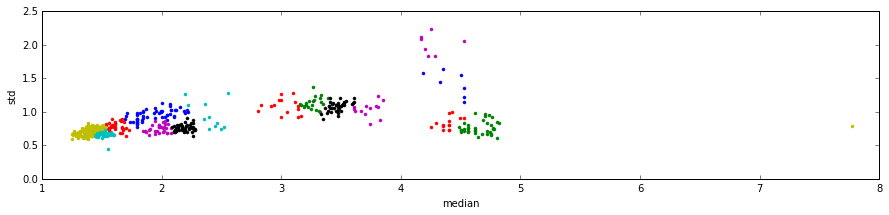

In [6]:
tic()
print("agencia...", num_clusters_agencia)
cluster_and_save('Agencia_ID', num_clusters_agencia)
tac()

ruta...  80
Time passed: 0hour:0min:8sec


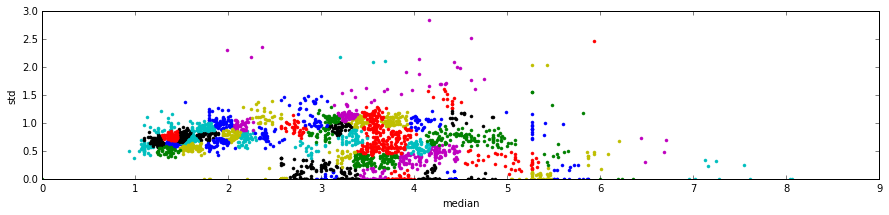

In [7]:
tic()
print("ruta... ", num_clusters_ruta)
cluster_and_save('Ruta_SAK', num_clusters_ruta)
tac()

prod... 45
Time passed: 0hour:0min:7sec


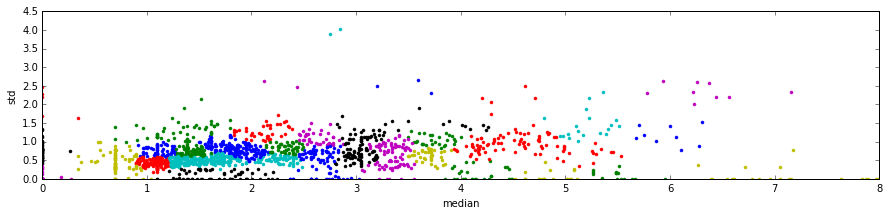

In [8]:
tic()
print("prod...", num_clusters_producto)
cluster_and_save('Producto_ID', num_clusters_producto)
tac()

In [ ]:
tic()
print("client...", num_clusters_cliente)
cluster_and_save('Cliente_ID', num_clusters_cliente)
tac()

client... 400


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.vie